# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
import numpy as np
import pandas as pd
from glob import glob
import cv2  
import random
from extract_bottleneck_features import *
from PIL import ImageFile   
from tqdm import tqdm

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import np_utils

import matplotlib.pyplot as plt                        
%matplotlib inline 


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
print('Shape of train_files {}'.format(train_files.shape))
print('Shape of train_targets {}\n'.format(train_targets.shape))
print('Shape of valid_files {}'.format(valid_files.shape))
print('Shape of valid_targets {}\n'.format(valid_targets.shape))
print('Shape of test_files {}'.format(test_files.shape))
print('Shape of test_targets {}'.format(test_targets.shape))

Shape of train_files (6680,)
Shape of train_targets (6680, 133)

Shape of valid_files (835,)
Shape of valid_targets (835, 133)

Shape of test_files (836,)
Shape of test_targets (836, 133)


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


# Get a sense of what the data looks like

In [4]:
train_files[0]

'../../../data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg'

In [5]:
train_targets[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

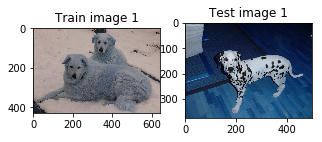

In [6]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
img = cv2.imread(train_files[0])
plt.imshow(img, cmap='gray')
plt.title('Train image 1');

# Display the first image in testing data
plt.subplot(122)
img2 = cv2.imread(test_files[0])
plt.imshow(img2, cmap='gray')
plt.title('Test image 1');

In [7]:
dog_names[:10]

['ages/train/001.Affenpinscher',
 'ages/train/002.Afghan_hound',
 'ages/train/003.Airedale_terrier',
 'ages/train/004.Akita',
 'ages/train/005.Alaskan_malamute',
 'ages/train/006.American_eskimo_dog',
 'ages/train/007.American_foxhound',
 'ages/train/008.American_staffordshire_terrier',
 'ages/train/009.American_water_spaniel',
 'ages/train/010.Anatolian_shepherd_dog']

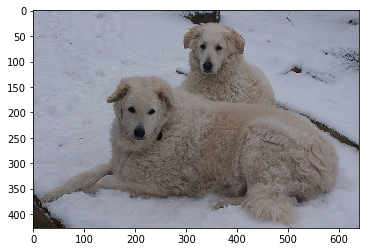

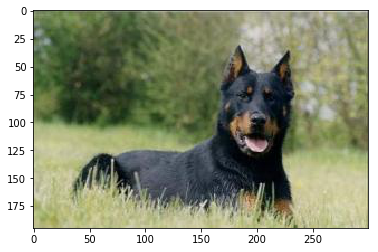

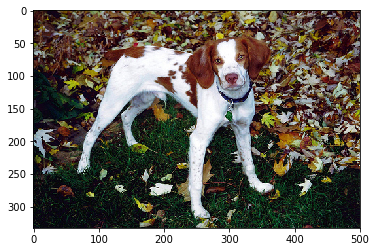

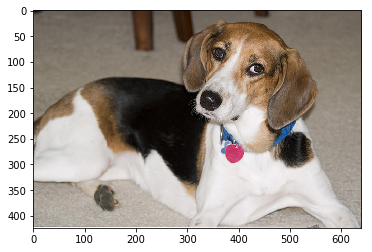

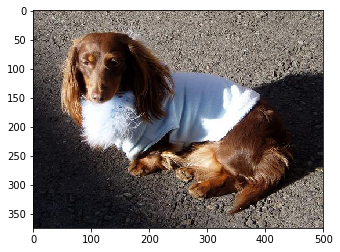

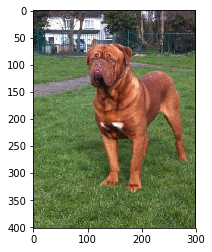

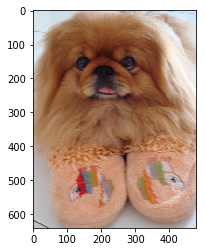

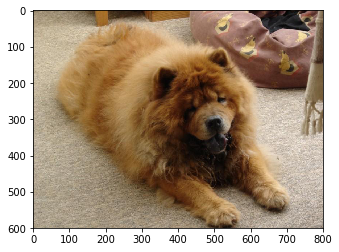

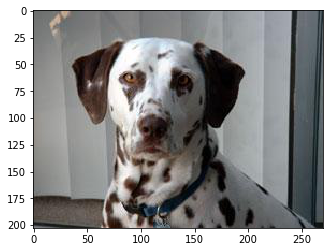

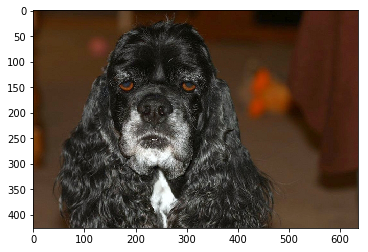

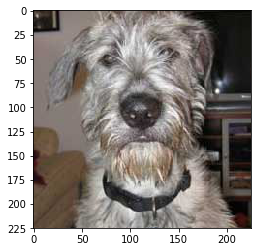

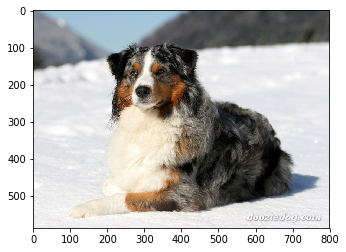

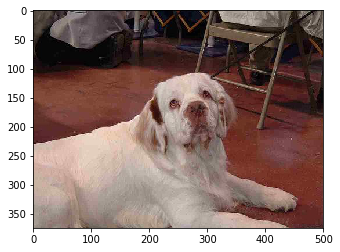

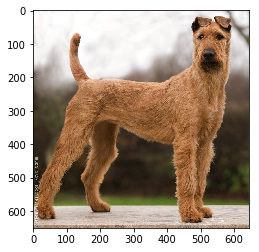

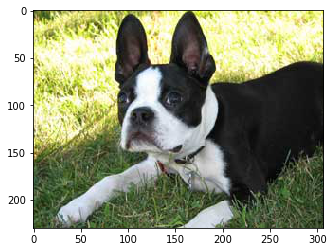

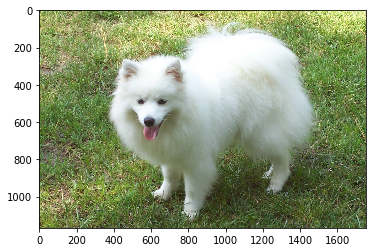

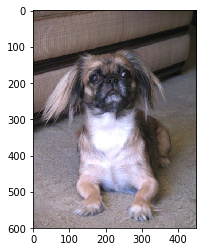

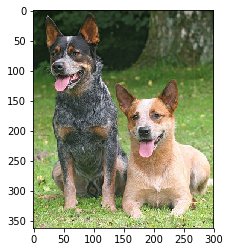

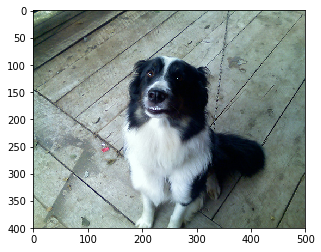

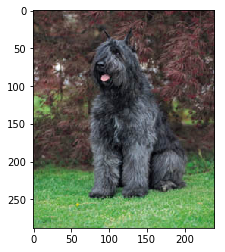

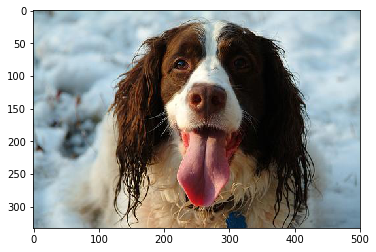

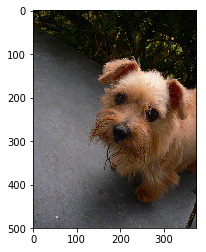

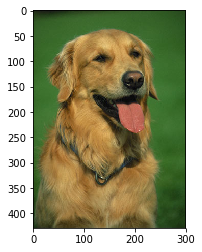

In [82]:
for i in range(len(train_files)):
    if i % 300 == 0:
        show_image(train_files[i])

## Image Quality
* Looking at a randome subset of images, it is easy to see that picture quality varies
* Darker images or blurry images will make it harder to recognize the breed
* Images with multiple dogs will cause confusion in terms of which one to use


## What does the distribution of dog data look like in the Train data?

In [8]:
target_breeds = pd.DataFrame(data=np.argmax(train_targets, axis=-1), columns=['breed'])
target_breeds.head()

breed
0     94
1     56
2     87
3      7
4      7

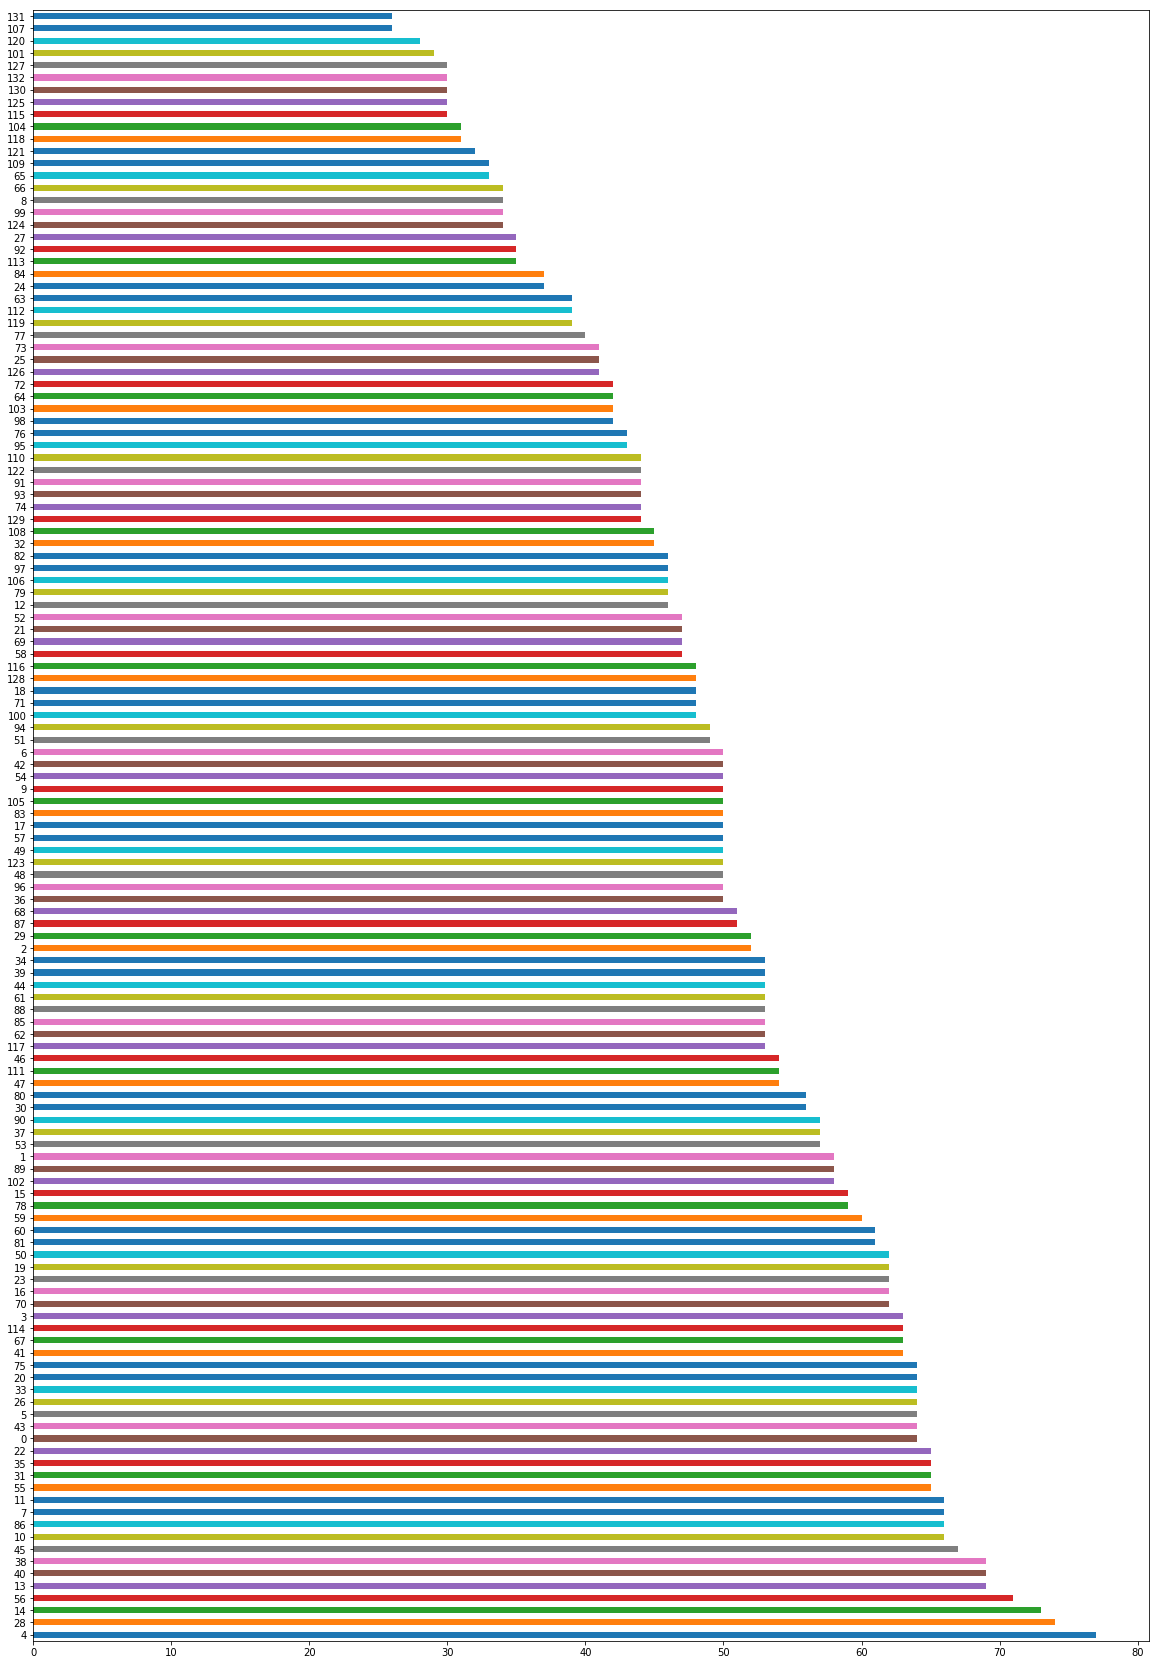

In [9]:
plt.figure(figsize=(20,30))
target_breeds['breed'].value_counts().plot(kind='barh');


In [10]:
target_breed_counts = pd.DataFrame(target_breeds.breed.value_counts())
target_breed_counts.rename(columns={"breed": "count"}, inplace=True)
target_breed_counts.sort_index(inplace=True)
target_breed_counts.index.rename('breed', inplace=True)
target_breed_counts.reset_index(inplace=True)
target_breed_counts.head()

breed  count
0      0     64
1      1     58
2      2     52
3      3     63
4      4     77

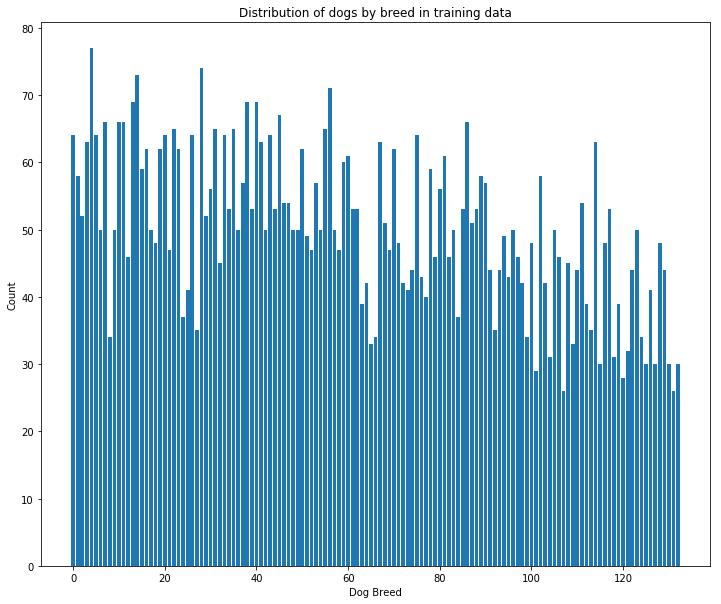

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
ax.bar(x=target_breed_counts['breed'], height=target_breed_counts['count']);
ax.set_title('Distribution of dogs by breed in training data')
ax.set_ylabel('Count')
ax.set_xlabel('Dog Breed');

In [16]:
target_breed_counts.describe()

breed       count
count  133.00000  133.000000
mean    66.00000   50.225564
std     38.53786   11.863885
min      0.00000   26.000000
25%     33.00000   42.000000
50%     66.00000   50.000000
75%     99.00000   61.000000
max    132.00000   77.000000

## What does the distribution of dog data look like in the test data?

In [17]:
test_breeds = pd.DataFrame(data=np.argmax(test_targets, axis=-1), columns=['breed'])
test_breeds.head()

breed
0     56
1     58
2    114
3     18
4     67

In [18]:
test_breed_counts = pd.DataFrame(test_breeds.breed.value_counts())
test_breed_counts.rename(columns={"breed": "count"}, inplace=True)
test_breed_counts.sort_index(inplace=True)
test_breed_counts.index.rename('breed', inplace=True)
test_breed_counts.reset_index(inplace=True)
test_breed_counts.head()

breed  count
0      0      8
1      1      8
2      2      6
3      3      8
4      4     10

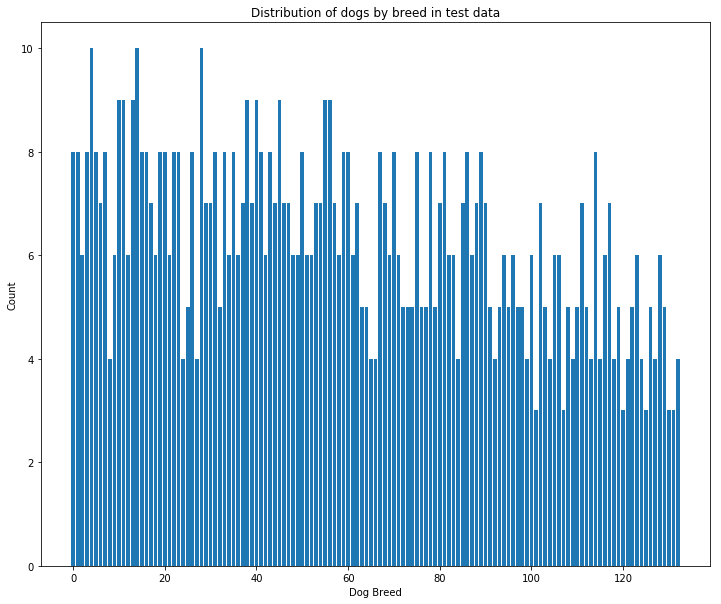

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
ax.bar(x=test_breed_counts['breed'], height=test_breed_counts['count']);
ax.set_title('Distribution of dogs by breed in test data')
ax.set_ylabel('Count')
ax.set_xlabel('Dog Breed');

In [201]:
test_breed_counts.describe()

breed       count
count  133.00000  133.000000
mean    66.00000    6.285714
std     38.53786    1.712571
min      0.00000    3.000000
25%     33.00000    5.000000
50%     66.00000    6.000000
75%     99.00000    8.000000
max    132.00000   10.000000

## Conclusions about the dog distribution
* The training data for dog breeds is not evenly distributed
* Some breeds have 3 times as much data as others
* The uneven distribution will result in the model being biased towards over represented breeds

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


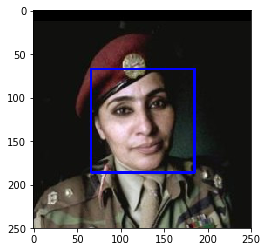

In [21]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [22]:
def show_faces(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [23]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

* 100.0 percent of the human files were humans
* 11.0 percent of the dog files were identified as humans

In [24]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detected = []
dog_detected = []
for i in range(100):
    human_detected.append(face_detector(human_files_short[i]))
    dog_detected.append(face_detector(dog_files_short[i]))
    
print('There were {} humans detected'.format(np.count_nonzero(human_detected)))
print('There were {} dogs detected as humans'.format(np.count_nonzero(dog_detected)))
print('{} percent of the human files were humans'.format(np.count_nonzero(human_detected) / 100 * 100))
print('{} percent of the dog files were identified as humans'.format(np.count_nonzero(dog_detected) / 100 * 100))

        

There were 100 humans detected
There were 11 dogs detected as humans
100.0 percent of the human files were humans
11.0 percent of the dog files were identified as humans


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

* In my opinion, it is reasonable to expect that the image provides a clear view of the face.  Having the clear view will have a direct correlation to how well the facial detection works.  I think the algorithm should be able to handle inverted faces and profiles of faces.

* If we want to detect humans in images where the face is not presented clearly, then the algorithm needs to be able to identify more than just the face.  Having the image show more of the body with an obscured face would still allow an image to be identified as human.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [25]:
def face_detector_2(face_classifier, img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)
    return len(faces) > 0

In [26]:
def get_face_detector_performance(face_classifier):
    humans_detected = []
    dogs_detected = []
    for i in range(100):
        humans_detected.append(face_detector_2(face_classifier, human_files_short[i]))
        dogs_detected.append(face_detector_2(face_classifier, dog_files_short[i]))

    print('There were {} humans detected'.format(np.count_nonzero(humans_detected)))
    print('There were {} dogs detected'.format(np.count_nonzero(dogs_detected)))
    print('{} percent of the human files were humans'.format(np.count_nonzero(humans_detected) / 100 * 100))
    print('{} percent of the dog files were dogs'.format(np.count_nonzero(dogs_detected) / 100 * 100))

In [27]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

# extract pre-trained face detector
profile_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_profileface.xml')
get_face_detector_performance(profile_cascade)

There were 50 humans detected
There were 2 dogs detected
50.0 percent of the human files were humans
2.0 percent of the dog files were dogs


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [28]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [29]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [30]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [31]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
 - 0% of the human files detected dog
 - 100% of the dog filed detected as dog.

In [32]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
rn50_humans_detected = []
rn50_dogs_detected = []
for i in range(100):
    rn50_humans_detected.append(dog_detector(human_files_short[i]))
    rn50_dogs_detected.append(dog_detector(dog_files_short[i]))

print('There were {} humans detected as dogs'.format(np.count_nonzero(rn50_humans_detected)))
print('There were {} dogs detected'.format(np.count_nonzero(rn50_dogs_detected)))
print('{} percent of the human files were dogs'.format(np.count_nonzero(rn50_humans_detected) / 100 * 100))
print('{} percent of the dog files were dogs'.format(np.count_nonzero(rn50_dogs_detected) / 100 * 100))

There were 0 humans detected as dogs
There were 100 dogs detected
0.0 percent of the human files were dogs
100.0 percent of the dog files were dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [33]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 87.91it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

* I started by creating my own model, but ran into some issue related to shape.
* I then scaled back and re-created the starter model provided.
* I added more convolutional layers with alternating strides between 1 and 2.
* For the CNNs, I kept increasing the number of filters in an effort to improve accuracy.
* I used a combination of Max Pooling and Global Average Pooling to reduce dimensionality.
* I added some drop out layers to minimize over fitting.
* I used relu as the activation to help with vanishing gradients and accuracy.
* I kept the padding set to 'same' so that there were no unknown areas of the image with the goal of improving accuracy.
* Later on, the data was augmented with horizontal and verticle shifting along with horizontal random flipping to drive up the accuracy further making the model more robust for the variability of where the dog might appear in the image.

In [34]:
# define the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=2, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=256, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

### Compile the Model

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [36]:
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 20


### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

train_hist = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 20s 3ms/step - loss: 4.8805 - acc: 0.0097 - val_loss: 4.8551 - val_acc: 0.0216
Epoch 2/20
6680/6680 [==============================] - 19s 3ms/step - loss: 4.7726 - acc: 0.0165 - val_loss: 4.6858 - val_acc: 0.0216
Epoch 3/20
6680/6680 [==============================] - 19s 3ms/step - loss: 4.6717 - acc: 0.0166 - val_loss: 4.6345 - val_acc: 0.0240
Epoch 4/20
6680/6680 [==============================] - 19s 3ms/step - loss: 4.5709 - acc: 0.0290 - val_loss: 4.4621 - val_acc: 0.0407
Epoch 5/20
6680/6680 [==============================] - 20s 3ms/step - loss: 4.4151 - acc: 0.0403 - val_loss: 4.3461 - val_acc: 0.0599
Epoch 6/20
6680/6680 [==============================] - 20s 3ms/step - loss: 4.2948 - acc: 0.0484 - val_loss: 4.2551 - val_acc: 0.0587
Epoch 7/20
6680/6680 [==============================] - 19s 3ms/step - loss: 4.1872 - acc: 0.0543 - val_loss: 4.1446 - val_acc: 0.0683
Epoch 8/

### Load the Model with the Best Validation Loss

In [37]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [40]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.6029%


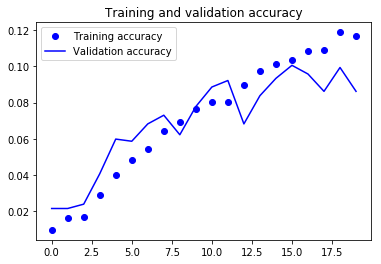

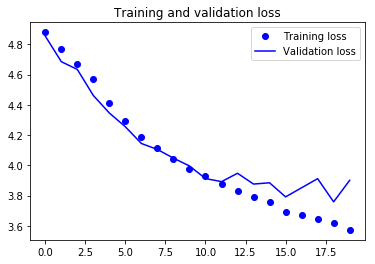

In [41]:
accuracy = train_hist.history['acc']
val_accuracy = train_hist.history['val_acc']
loss = train_hist.history['loss']
val_loss = train_hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Augment the data
* horizontal shift
* vertical shift
* random horizontal flip

In [42]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)

epochs = 15
batch_size=64

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

augmented_train_hist = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(valid_tensors, valid_targets),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/15
Epoch 00001: val_loss improved from inf to 3.74793, saving model to saved_models/weights.best.from_scratch.hdf5
 - 51s - loss: 3.7701 - acc: 0.1045 - val_loss: 3.7479 - val_acc: 0.1054
Epoch 2/15
Epoch 00002: val_loss improved from 3.74793 to 3.70022, saving model to saved_models/weights.best.from_scratch.hdf5
 - 50s - loss: 3.7895 - acc: 0.1029 - val_loss: 3.7002 - val_acc: 0.1198
Epoch 3/15
Epoch 00003: val_loss did not improve
 - 49s - loss: 3.7221 - acc: 0.1081 - val_loss: 3.7603 - val_acc: 0.1114
Epoch 4/15
Epoch 00004: val_loss improved from 3.70022 to 3.67999, saving model to saved_models/weights.best.from_scratch.hdf5
 - 50s - loss: 3.7199 - acc: 0.1068 - val_loss: 3.6800 - val_acc: 0.1114
Epoch 5/15
Epoch 00005: val_loss did not improve
 - 49s - loss: 3.6888 - acc: 0.1097 - val_loss: 3.7149 - val_acc: 0.1186
Epoch 6/15
Epoch 00006: val_loss improved from 3.67999 to 3.66689, saving model to saved_models/weights.best.from_scratch.hdf5
 - 50s - loss: 3.6724 - acc: 0.11

In [43]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [44]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 15.3110%


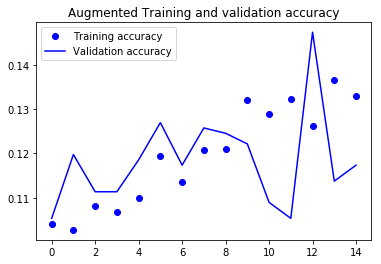

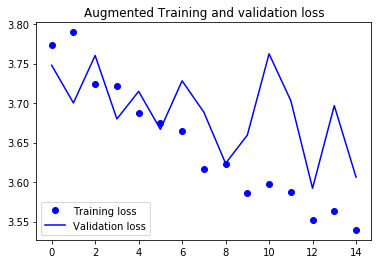

In [45]:
accuracy = augmented_train_hist.history['acc']
val_accuracy = augmented_train_hist.history['val_acc']
loss = augmented_train_hist.history['loss']
val_loss = augmented_train_hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Augmented Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Augmented Training and validation loss')
plt.legend()
plt.show()

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [46]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [47]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [48]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [49]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_hist = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 302us/step - loss: 12.9415 - acc: 0.1007 - val_loss: 11.5130 - val_acc: 0.1677
Epoch 2/20
6680/6680 [==============================] - 2s 259us/step - loss: 10.7425 - acc: 0.2416 - val_loss: 10.5067 - val_acc: 0.2587
Epoch 3/20
6680/6680 [==============================] - 2s 251us/step - loss: 10.0622 - acc: 0.3172 - val_loss: 10.1607 - val_acc: 0.2934
Epoch 4/20
6680/6680 [==============================] - 2s 254us/step - loss: 9.7451 - acc: 0.3507 - val_loss: 9.9109 - val_acc: 0.3222
Epoch 5/20
6680/6680 [==============================] - 2s 253us/step - loss: 9.5587 - acc: 0.3763 - val_loss: 9.8010 - val_acc: 0.3293
Epoch 6/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.3821 - acc: 0.3943 - val_loss: 9.7021 - val_acc: 0.3329
Epoch 7/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.2681 - acc: 0.4010 - val_loss: 9.6624 - val_acc: 0.

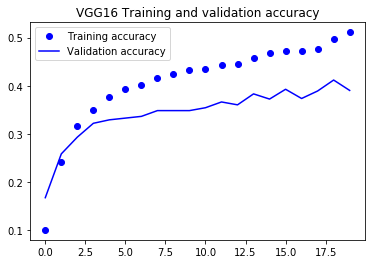

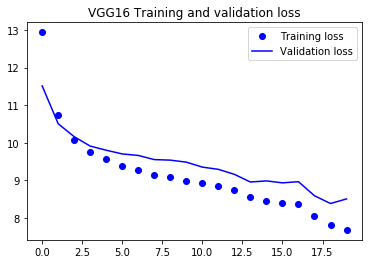

In [50]:
accuracy = VGG16_hist.history['acc']
val_accuracy = VGG16_hist.history['val_acc']
loss = VGG16_hist.history['loss']
val_loss = VGG16_hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('VGG16 Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('VGG16 Training and validation loss')
plt.legend()
plt.show()

### Load the Model with the Best Validation Loss

In [51]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [52]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.9856%


In [94]:
score = VGG16_model.evaluate(train_VGG16, train_targets, verbose=0)
print('VGG_16 Scores')
print('Train loss:', score[0])
print('Train accuracy:', score[1] * 100)
print('\n')

score = VGG16_model.evaluate(valid_VGG16, valid_targets, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1] * 100)
print('\n')

score = VGG16_model.evaluate(test_VGG16, test_targets, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1] * 100)

VGG_16 Scores
Train loss: 7.67161394222
Train accuracy: 51.392215576


Valid loss: 8.3827978651
Valid accuracy: 41.1976047976


Test loss: 8.38729292582
Test accuracy: 41.985645933


### Predict Dog Breed with the Model

In [53]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [54]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

* I started with the provide basic model and then added additional convolutional layers with increasing filters, dropout, and dense layers.  I started with a few, and then added additional layers and some adjustments to stride to improve the model accuracy.
* Then I added data augmentation into the mix to improve the robustness of the model in terms of the placement of objects within the images.
* With transfer learning, using ResNet50, I was able to improve the model test accuracy from 13.7560% to 78.9474%.  The model using VGG16 only achieved a test accuracy of 44.2584%.


In [55]:
### TODO: Define your architecture.
resnet50_model = Sequential()
resnet50_model.add(GlobalAveragePooling2D(input_shape=train_resnet50.shape[1:]))
resnet50_model.add(Dense(133, activation='softmax'))

resnet50_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [56]:
### TODO: Compile the model.
resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [57]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_hist = resnet50_model.fit(train_resnet50, train_targets, 
          validation_data=(valid_resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 280us/step - loss: 1.6385 - acc: 0.6033 - val_loss: 0.8492 - val_acc: 0.7413
Epoch 2/20
6680/6680 [==============================] - 2s 225us/step - loss: 0.4433 - acc: 0.8572 - val_loss: 0.7210 - val_acc: 0.7749
Epoch 3/20
6680/6680 [==============================] - 2s 226us/step - loss: 0.2560 - acc: 0.9204 - val_loss: 0.6863 - val_acc: 0.8012
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1767 - acc: 0.9448 - val_loss: 0.6750 - val_acc: 0.7892
Epoch 5/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1226 - acc: 0.9603 - val_loss: 0.6579 - val_acc: 0.8048
Epoch 6/20
6680/6680 [==============================] - 2s 226us/step - loss: 0.0891 - acc: 0.9720 - val_loss: 0.6603 - val_acc: 0.8240
Epoch 7/20
6680/6680 [==============================] - 2s 225us/step - loss: 0.0634 - acc: 0.9810 - val_loss: 0.7169 - val_acc: 0.8168
E

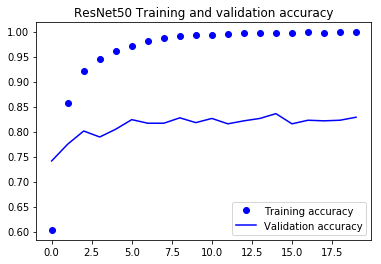

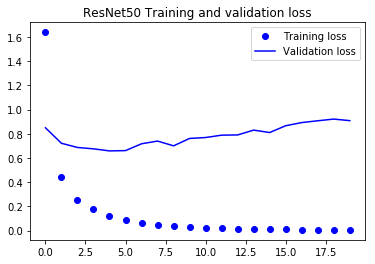

In [58]:
accuracy = resnet50_hist.history['acc']
val_accuracy = resnet50_hist.history['val_acc']
loss = resnet50_hist.history['loss']
val_loss = resnet50_hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('ResNet50 Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('ResNet50 Training and validation loss')
plt.legend()
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [59]:
### TODO: Load the model weights with the best validation loss.
resnet50_model.load_weights('saved_models/weights.best.resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [88]:
score = resnet50_model.evaluate(train_resnet50, train_targets, verbose=0)
print('ResNet-50 Scores')
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('\n')

score = resnet50_model.evaluate(valid_resnet50, valid_targets, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])
print('\n')

score = resnet50_model.evaluate(test_resnet50, test_targets, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ResNet-50 Scores
Train loss: 0.0624164708472
Train accuracy: 0.982335329341


Valid loss: 0.657947618401
Valid accuracy: 0.804790419162


Test loss: 0.734945538797
Test accuracy: 0.813397129187


In [96]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## Try InceptionV3 model

In [61]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [62]:
### TODO: Define your architecture.
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [63]:
### TODO: Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [64]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_hist = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 389us/step - loss: 1.1510 - acc: 0.7084 - val_loss: 0.6738 - val_acc: 0.7940
Epoch 2/20
6680/6680 [==============================] - 2s 320us/step - loss: 0.4818 - acc: 0.8528 - val_loss: 0.6488 - val_acc: 0.8287
Epoch 3/20
6680/6680 [==============================] - 2s 304us/step - loss: 0.3672 - acc: 0.8840 - val_loss: 0.6299 - val_acc: 0.8443
Epoch 4/20
6680/6680 [==============================] - 2s 302us/step - loss: 0.2858 - acc: 0.9123 - val_loss: 0.6787 - val_acc: 0.8335
Epoch 5/20
6680/6680 [==============================] - 2s 304us/step - loss: 0.2423 - acc: 0.9238 - val_loss: 0.6954 - val_acc: 0.8443
Epoch 6/20
6680/6680 [==============================] - 2s 304us/step - loss: 0.2088 - acc: 0.9356 - val_loss: 0.7113 - val_acc: 0.8419
Epoch 7/20
6680/6680 [==============================] - 2s 307us/step - loss: 0.1688 - acc: 0.9479 - val_loss: 0.7451 - val_acc: 0.8455
E

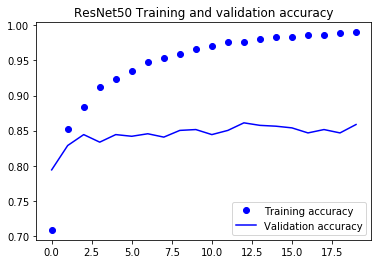

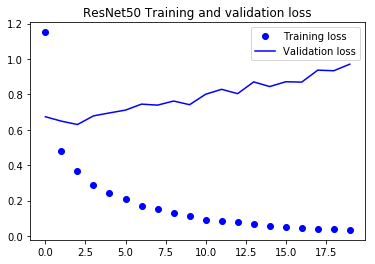

In [65]:
accuracy = InceptionV3_hist.history['acc']
val_accuracy = InceptionV3_hist.history['val_acc']
loss = InceptionV3_hist.history['loss']
val_loss = InceptionV3_hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('ResNet50 Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('ResNet50 Training and validation loss')
plt.legend()
plt.show()

In [66]:
### TODO: Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [68]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


In [90]:
score = InceptionV3_model.evaluate(train_InceptionV3, train_targets, verbose=0)
print('InceptionV3 Scores')
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('\n')

score = InceptionV3_model.evaluate(valid_InceptionV3, valid_targets, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])
print('\n')

score = InceptionV3_model.evaluate(test_InceptionV3, test_targets, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

InceptionV3 Scores
Train loss: 0.237383892484
Train accuracy: 0.922305389222


Valid loss: 0.629907760649
Valid accuracy: 0.844311377317


Test loss: 0.771796618922
Test accuracy: 0.816985645933


In [95]:
def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [69]:
dog_names[0]

'ages/train/001.Affenpinscher'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

### Dog Breed Predictor Algorithm

#### Dog Detector:
* Convert color channels and normalize the image using eras preprocess_input
* Resize the image to 224x224
* Convert the image to a 3D tensor with shape 224x224x3 (height, width, and depth for color channels)
* Convert 3D tensor to 4D tensor with shape 1x224x224x3
* Get prediction
* Use np.argmax to get the predicted object category
* Return true/false based on if the object category falls in the range of 151 to 268 inclusive

#### Human Detector input requirements
* Convert the image to grayscale
* Detect faces
* Return true if number of faces found is > 0

#### Dog Breed Predictor
* Same input handling as was used for the dog detector
* If the object category falls in the range of 151 to 268 inclusive, use the category number as the index to look up the breed name in the dog_names array.

#### Algorithm
* Detect humans
* Detect dogs
* If human or dogs found, predict breed
* Return breed detected or error if no dogs or humans were detected

In [97]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def reformat_breed(breed):
    offset_delim = breed.rfind('.')
    last_n = len(breed) - offset_delim - 1
    breed = (breed[-last_n:])
    return breed

def dog_breed(image_path, face_classifier):
    detected_breed = []
    msg = []

    # is the image a human or a dog?
    is_dog = dog_detector(image_path)
    is_human = face_detector_2(face_classifier, image_path)
    
    if is_dog == True:
        breed = reformat_breed(InceptionV3_predict_breed(image_path))
        temp_msg = 'A dog resembling the {} breed was detected'
        detected_breed.append(breed)
        msg.append(temp_msg.format(breed))
    if is_human == True:
        breed = reformat_breed(InceptionV3_predict_breed(image_path))
        temp_msg = 'A human resembling a {} was detected'
        detected_breed.append(breed)
        msg.append(temp_msg.format(breed))
    if is_dog == False and is_human == False:
        breed = 'No dogs or humans were detected'
        temp_msg = 'Error: {}'
        detected_breed.append(breed)
        msg.append(temp_msg.format(breed))
        
    return (detected_breed, msg)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
* The output was about what I expected. 
* Humans in costumes, were not identified as human or dogs.
* Breeds with a lot of variability in coloration were not as accurately classified.
* Better images lead to better identification and classification.
* Data augmentation improves the robustness and accuracy of the model.
* There is a lot of vagueness about picking the right parameters in terms of steps and filters and how many layers to use!

In [98]:
def show_image(image_path):
    # load color (BGR) image
    img = cv2.imread(image_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(cv_rgb)
    plt.show()

------------------------------------------------------

File sent for prediction: ./images/sample_human_2.png


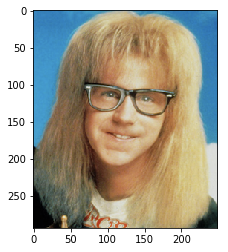

87916544/87910968 [==============================] - 2s 0us/step
A human resembling a Dachshund was detected

------------------------------------------------------

File sent for prediction: ./images/Welsh_springer_spaniel_08203.jpg


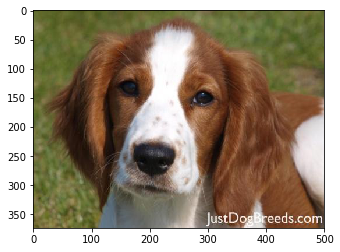

A dog resembling the Welsh_springer_spaniel breed was detected

------------------------------------------------------

File sent for prediction: ./images/Brittany_02625.jpg


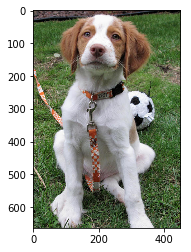

A dog resembling the Brittany breed was detected

------------------------------------------------------

File sent for prediction: ./images/Labrador_retriever_06449.jpg


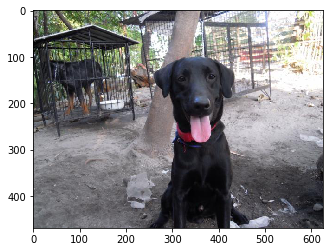

A dog resembling the Labrador_retriever breed was detected

------------------------------------------------------

File sent for prediction: ./images/human_dog4.jpeg


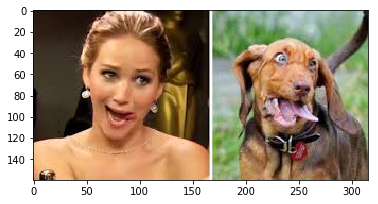

A dog resembling the Dogue_de_bordeaux breed was detected

A human resembling a Dogue_de_bordeaux was detected

------------------------------------------------------

File sent for prediction: ./images/Curly-coated_retriever_03896.jpg


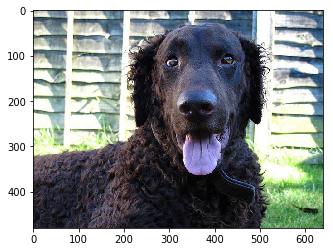

A dog resembling the Curly-coated_retriever breed was detected

------------------------------------------------------

File sent for prediction: ./images/sample_cnn.png


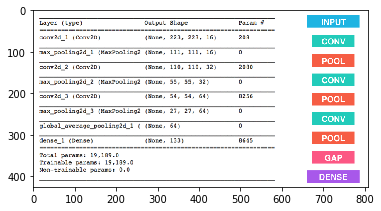

Error: No dogs or humans were detected

------------------------------------------------------

File sent for prediction: ./images/Labrador_retriever_06455.jpg


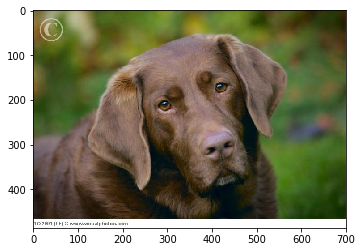

A dog resembling the Labrador_retriever breed was detected

------------------------------------------------------

File sent for prediction: ./images/human_dog1.jpeg


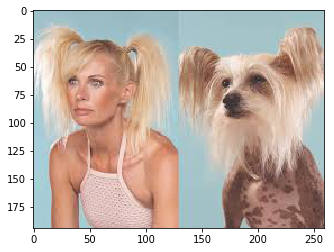

A dog resembling the Chinese_crested breed was detected

A human resembling a Chinese_crested was detected

------------------------------------------------------

File sent for prediction: ./images/Labrador_retriever_06457.jpg


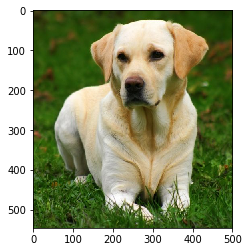

A dog resembling the Labrador_retriever breed was detected

------------------------------------------------------

File sent for prediction: ./images/human_dog5.jpeg


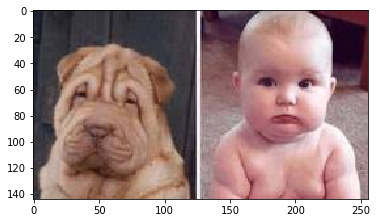

A human resembling a Dogue_de_bordeaux was detected

------------------------------------------------------

File sent for prediction: ./images/human_dog2.jpeg


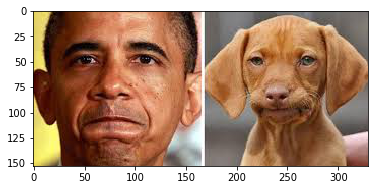

A dog resembling the Dogue_de_bordeaux breed was detected

A human resembling a Dogue_de_bordeaux was detected

------------------------------------------------------

File sent for prediction: ./images/sample_dog_output.png


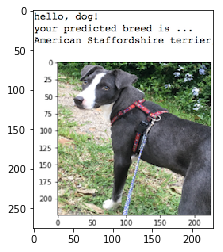

Error: No dogs or humans were detected

------------------------------------------------------

File sent for prediction: ./images/goofiness 003.JPG


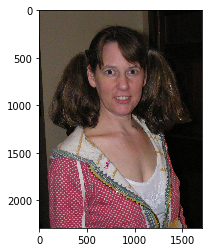

A human resembling a Smooth_fox_terrier was detected

------------------------------------------------------

File sent for prediction: ./images/sample_human_output.png


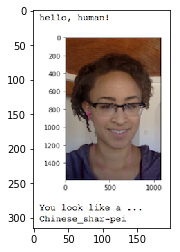

A human resembling a Cavalier_king_charles_spaniel was detected

------------------------------------------------------

File sent for prediction: ./images/human_dog3.jpeg


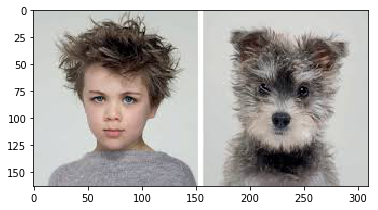

A dog resembling the Norfolk_terrier breed was detected

A human resembling a Norfolk_terrier was detected

------------------------------------------------------

File sent for prediction: ./images/American_water_spaniel_00648.jpg


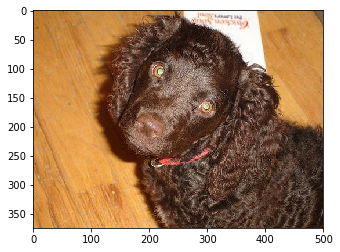

A dog resembling the American_water_spaniel breed was detected



In [99]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
face_classifier = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

for my_img in glob('./images/*.*'): 
    print('------------------------------------------------------')
    print('\nFile sent for prediction: {}'.format(my_img))
    show_image(my_img)
    breed, msg = dog_breed(my_img, face_classifier)
    for i in range(len(breed)):
        print('{}\n'.format(msg[i], breed[i]))


## Recap

* Human Face detection used pre-trained OpenCV model and achieved a test accuracy of 100% given human images
* Dog detection used a pre-trained ResNet-50 model and achieved a test accuracy of 100% given dog images
* CNN created from scratch achieved a base test accuracy of 11.6029% surpassing the 1% minimum
* CNN created from scratch with data augmentation achieved a test accuracy of 15.3110%
* Transfer learning CNN based on ResNet-50 pre-trained model achieved a test accuracy of 81.3397% surpassing the 60% minimum